# [COM4513-6513] Assignment 1: Text Classification with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test two text classification systems: 

- **Task 1:** sentiment analysis, in particular to predict the sentiment of movie review, i.e. positive or negative (binary classification).
- **Task 2:** topic classification, to predict whether a news article is about International issues, Sports or Business (multiclass classification).


For that purpose, you will implement:

- Text processing methods for extracting Bag-Of-Word features, using (1) unigrams, bigrams and trigrams to obtain vector representations of documents. Two vector weighting schemes should be tested: (1) raw frequencies (**3 marks; 1 for each ngram type**); (2) tf.idf (**1 marks**). 
- Binary Logistic Regression classifiers that will be able to accurately classify movie reviews trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 1. 
- Multiclass Logistic Regression classifiers that will be able to accurately classify news articles trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 2. 
- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function for Task 1 (**3 marks**)
    - Minimise the Categorical Cross-entropy loss function for Task 2 (**3 marks**)
    - Use L2 regularisation (both tasks) (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous validation loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)
- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength)?  (**2 marks; 0.5 for each model in each task**).
- After training the LR models, plot the learning process (i.e. training and validation loss in each epoch) using a line plot (**1 mark; 0.5 for both BOW-count and BOW-tfidf LR models in each task**) and discuss if your model overfits/underfits/is about right.
- Model interpretability by showing the most important features for each class (i.e. most positive/negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!).  If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks; 0.5 for BOW-count and BOW-tfidf LR models respectively in each task**)


### Data - Task 1 

The data you will use for Task 1 are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.

### Data - Task 2

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.


### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc..

Please make sure to comment your code. You should also mention if you've used Windows (not recommended) to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Fri, 20 Mar 2020** and it needs to be submitted via MOLE. Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
# fill in your code...
class FileLoader:
    def __init__(self,path,File=None,names=['text','label']):
        self.path = self.__load_path(path)
        self.names = names
        self.__load_data(File)
        
    def __load_path(self,path):
        import os
        if os.path.exists(path):
            return path
        else:
            print("Path not exist!")
    
    def __load_datum(self,files_name):
        import os
        full_path = self.path +'/'+files_name.strip().strip('/')
        if os.path.exists(full_path):
            return pd.read_csv(full_path,header=None,names=self.names)
        else:
            print("File not exist!")
            
    def __load_data(self,File):
        if File==None:
            self.train = self.__load_datum('train.csv')
            self.test = self.__load_datum('test.csv')
            self.dev = self.__load_datum('dev.csv')
            print('Finish loading:\n\ttrain.csv\n\ttest.csv\n\tdev.csv')
        else:
            self.data = self.__load_datum(File)
            print('Finish loading:\n\t'+File)

Data = FileLoader('data_sentiment')

data_tr = Data.train
data_te = Data.test
data_dev = Data.dev

Finish loading:
	train.csv
	test.csv
	dev.csv


If you use Pandas you can see a sample of the data.

In [3]:
data_tr.head()

,text,label
0,note : some may consider portions of the follo...,1
1,note : some may consider portions of the follo...,1
2,every once in a while you see a film that is s...,1
3,"when i was growing up in 1970s , boys in my sc...",1
4,"the muppet movie is the first , and the best m...",1


In [21]:
len(data_tr)

1400

The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [4]:
# fill in your code...
def transform(df):
    return list(df['text']), df['label'].to_numpy().reshape(-1,1)

X_tr_raw, Y_tr = transform(data_tr)
X_te_raw, Y_te = transform(data_te)
X_dev_raw, Y_dev = transform(data_dev)

In [5]:
X_tr_raw[:1]

['note : some may consider portions of the following text to be spoilers .  be forewarned .  it\'s startling to consider that it was only a few years ago that film distributors would worriedly rearrange their summer release schedules in order to give the annual disney animated feature juggernaut a wide berth .  the lion king had just cracked $300 million domestic in gross to become one of the most profitable ventures in film history , continuing to build on a sturdy base left by prior flicks aladdin and beauty and the beast .  since then , though , disney\'s animated features have shown an unbroken string of diminishing returns , with pocahontas , the hunchback of notre dame , and this year\'s hercules successively proving less and less potent .  with the once seemingly-impregnable disney stranglehold on the market share suddenly looking mighty vulnerable , and faced with their first serious competition in the animated film market from fox\'s anastasia , disney has brought xmas home ea

In [6]:
Y_tr

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

# Bag-of-Words Representation 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (you can keep top N if you encounter memory issues).


In [7]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they' 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.

See the examples below to see how this function should work.

In [8]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    """N-gram extraction from a document.

    Args:
        x_raw: a string corresponding to the raw text of a document
        ngram_range: a tuple of two integers denoting the type of ngrams you want
            to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
        token_pattern: a string to be used within a regular expression to extract
            all tokens. Note that data is already tokenised so you could opt for
            a simple white space tokenisation.
        stop_words: a list of stop words
        vocab: a given vocabulary. It should be used to extract specific features.

    Returns:
        A list of terms to the corresponding N-gram. Each part fits one N-gram,
        except 1-gramrow. For example:

        ['great','movie','watch',
        ('great', 'movie'),('movie', 'watch'),
        ('great', 'movie', 'watch')]

    """
    def finder(s,n,features = set()):
        if n <= 0 or n > len(s):
            raise Exception('n is out of range')
        if len(features) == 0:
            if n == 1:
                return s
            else:
                return map(lambda i: tuple(s[i:i+n]),range(len(s)-n+1))
        else:
            if n == 1:
                return [t for t in s if t in features]
            else:
                return [tuple(s[i:i+n]) for i in range(0,len(s)-n+1) if tuple(s[i:i+n]) in features]

    # Find all words by condition
    pattern = re.compile(token_pattern)
    term_eligible = [term for term in pattern.findall(x_raw) if term not in stop_words]

    # Find combinations of different N-grams
    x = [term for n in range(ngram_range[0],ngram_range[1]+1) for term in finder(term_eligible,n,vocab)]
        
    return x

In [46]:
"a"

'a'

In [8]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    """N-gram extraction from a document.

    Args:
        x_raw: a string corresponding to the raw text of a document
        ngram_range: a tuple of two integers denoting the type of ngrams you want
            to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
        token_pattern: a string to be used within a regular expression to extract
            all tokens. Note that data is already tokenised so you could opt for
            a simple white space tokenisation.
        stop_words: a list of stop words
        vocab: a given vocabulary. It should be used to extract specific features.

    Returns:
        A list of terms to the corresponding N-gram. Each part fits one N-gram,
        except 1-gramrow. For example:

        ['great','movie','watch',
        ('great', 'movie'),('movie', 'watch'),
        ('great', 'movie', 'watch')]

    """
    def finder(s,n):
        if n <= 0 or n > len(s):
            raise Exception('n is out of range')
        if n == 1:
            return s
        else:
            return map(lambda i: tuple(s[i:i+n]),range(len(s)-n+1))

    # Find all words by condition
    pattern = re.compile(token_pattern)
    term_eligible = [term.lower() for term in pattern.findall(x_raw) if term.lower() not in stop_words]

    # Find combinations of different N-grams
    x = [term for n in range(ngram_range[0],ngram_range[1]+1) for term in finder(term_eligible,n)]
    
    if not vocab:    
        return x
    else:
        return [term for term in x if term in vocab]

In [9]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,3), 
               stop_words=stop_words)

['great',
 'movie',
 'watch',
 ('great', 'movie'),
 ('movie', 'watch'),
 ('great', 'movie', 'watch')]

In [10]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,2), 
               stop_words=stop_words, 
               vocab=set(['great',  ('great','movie')]))

['great', ('great', 'movie')]

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [11]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[]):
    '''1. create a vocabulary of ngrams
       2. count the document frequencies of ngrams
       3. their raw frequency

    Args:
        X_raw: a list of strings each corresponding to the raw text of a document
        ngram_range: a tuple of two integers denoting the type of ngrams you want
            to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
        token_pattern: a string to be used within a regular expression to extract
            all tokens. Note that data is already tokenised so you could opt for
            a simple white space tokenisation.
        stop_words: a list of stop words
        min_df: keep ngrams with a minimum document frequency.
        keep_topN: keep top-N more frequent ngrams.

    Returns:
        vocab: a set of the n-grams that will be used as features.
        df: a Counter (or dict) that contains ngrams as keys and their corresponding
            document frequency as values.
        ngram_counts: counts of each ngram in vocab
        For example,

    '''
    df = dict()
    bag_of_ngrams = list()
    for line in X_tr_raw:
        ngrams = extract_ngrams(line,ngram_range=(1,3),token_pattern=token_pattern,stop_words=stop_words)
        bag_of_ngrams += ngrams
        for ngram in set(ngrams):
            df[ngram] = df.get(ngram,0) + 1
    vocab_df = {k:v for k,v in df.items() if v>=min_df}
    ngram_counts = Counter(bag_of_ngrams)
    vocab = list(set([ngram[0] for ngram in ngram_counts.most_common() if ngram[0] in vocab_df.keys()][:keep_topN]))

    return vocab, Counter(df), ngram_counts

In [11]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[]):
    '''1. create a vocabulary of ngrams
       2. count the document frequencies of ngrams
       3. their raw frequency

    Args:
        X_raw: a list of strings each corresponding to the raw text of a document
        ngram_range: a tuple of two integers denoting the type of ngrams you want
            to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
        token_pattern: a string to be used within a regular expression to extract
            all tokens. Note that data is already tokenised so you could opt for
            a simple white space tokenisation.
        stop_words: a list of stop words
        min_df: keep ngrams with a minimum document frequency.
        keep_topN: keep top-N more frequent ngrams.

    Returns:
        vocab: a set of the n-grams that will be used as features.
        df: a Counter (or dict) that contains ngrams as keys and their corresponding
            document frequency as values.
        ngram_counts: counts of each ngram in vocab
        For example,

    '''
    bag_of_ngrams = list()
    df = Counter()
    for line in X_raw:
        ngrams = extract_ngrams(line,ngram_range=(1,3),token_pattern=token_pattern,stop_words=stop_words)
        bag_of_ngrams += ngrams
        df.update(set(ngrams))
    df = Counter({k:v for k,v in df.items() if v >=min_df})
    ngram_counts = Counter(bag_of_ngrams)
    
    vocab = [items[0] for items in ngram_counts.most_common()[:keep_topN]]

    return vocab, df, ngram_counts

In [11]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[]):
    '''1. create a vocabulary of ngrams
       2. count the document frequencies of ngrams
       3. their raw frequency

    Args:
        X_raw: a list of strings each corresponding to the raw text of a document
        ngram_range: a tuple of two integers denoting the type of ngrams you want
            to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
        token_pattern: a string to be used within a regular expression to extract
            all tokens. Note that data is already tokenised so you could opt for
            a simple white space tokenisation.
        stop_words: a list of stop words
        min_df: keep ngrams with a minimum document frequency.
        keep_topN: keep top-N more frequent ngrams.

    Returns:
        vocab: a set of the n-grams that will be used as features.
        df: a Counter (or dict) that contains ngrams as keys and their corresponding
            document frequency as values.
        ngram_counts: counts of each ngram in vocab
        For example,

    '''
    bag_of_ngrams = list()
    df = Counter()
    for line in X_raw:
        ngrams = extract_ngrams(line,ngram_range=(1,3),token_pattern=token_pattern,stop_words=stop_words)
        bag_of_ngrams += ngrams
        df.update(set(ngrams))
    df = Counter({k:v for k,v in df.items() if v >=min_df})
    ngram_counts = Counter(bag_of_ngrams)
    
    vocab = [items[0] for items in ngram_counts.most_common() if items[0] in df.keys()][:keep_topN]

    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [12]:
vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['film', 'but', 'one', 'movie', 'not', 'all', 'there', 'like', 'so', 'out', 'about', 'more', 'up', 'when', 'their', 'some', 'just', 'if', 'into', 'him', 'even', 'only', 'no', 'than', 'time', 'good', 'most', 'story', 'will', 'would', 'much', 'character', 'also', 'get', 'two', 'well', 'characters', 'other', 'very', 'first', 'see', 'after', 'because', 'way', 'make', 'off', 'plot', 'while', 'had', 'any', 'too', 'little', 'life', 'films', 'does', 'where', 'people', 'then', 'how', 'me', 'really', 'man', 'scene', 'my', 'never', 'bad', 'being', 'over', 'best', 'don', 'scenes', 'doesn', 'many', 'new', 'know', 'director', 'here', 'action', 'such', 'great', 'through', 'movies', 're', 'love', 'another', 'made', 'go', 'big', 'end', 'seems', 'something', 'still', 'back', 'world', 'us', 'work', 'now', 'down', 'before', 'makes']

[('but', 1334), ('one', 1247), ('film', 1231), ('not', 1170), ('all', 1117), ('movie', 1095), ('out', 1080), ('so', 1047), ('there', 1046), ('like', 1043)]


In [10]:
vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['manages', 'questions', 'covered', 'body', 'ron', 'flair', 'drunken', 'approach', 'etc', 'allowing', 'lebowski', 'strong', 'model', 'category', 'family', 'couldn', 'argento', 'why', 'shown', ('doesn', 'work'), 'ocean', ('lot', 'more'), 'lou', 'attorney', 'kick', 'thinking', 'worth', 'larger', ('waste', 'time'), ('back', 'forth'), 'roles', 'adventures', ('million', 'dollars'), 'critics', 'according', ('ghost', 'dog'), 'outside', 'protect', ('last', 'time'), ('but', 'so'), 'creative', 'sell', 'pile', 'needless', 'immediately', 'screens', 'cards', 'blonde', 'meets', 'place', 'needs', 'needed', 'teacher', 'conceived', 'competition', 'powerful', 'expected', ('first', 'movie'), ('but', 'least'), 'gave', 'pleasures', 'spectacular', 'safe', 'wishes', 'stuff', ('there', 'something'), 'robert', 'kid', 'latest', ('bad', 'guy'), 'comet', 'street', 'intelligent', 'allow', ('tim', 'roth'), ('production', 'design'), 'living', 'abyss', 'clean', ('makes', 'him'), 'aware', 'footage', 'vicious', '

Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [13]:
reference_dict = dict(enumerate(vocab))
reference_dict

{0: 'film',
 1: 'but',
 2: 'one',
 3: 'movie',
 4: 'not',
 5: 'all',
 6: 'there',
 7: 'like',
 8: 'so',
 9: 'out',
 10: 'about',
 11: 'more',
 12: 'up',
 13: 'when',
 14: 'their',
 15: 'some',
 16: 'just',
 17: 'if',
 18: 'into',
 19: 'him',
 20: 'even',
 21: 'only',
 22: 'no',
 23: 'than',
 24: 'time',
 25: 'good',
 26: 'most',
 27: 'story',
 28: 'will',
 29: 'would',
 30: 'much',
 31: 'character',
 32: 'also',
 33: 'get',
 34: 'two',
 35: 'well',
 36: 'characters',
 37: 'other',
 38: 'very',
 39: 'first',
 40: 'see',
 41: 'after',
 42: 'because',
 43: 'way',
 44: 'make',
 45: 'off',
 46: 'plot',
 47: 'while',
 48: 'had',
 49: 'any',
 50: 'too',
 51: 'little',
 52: 'life',
 53: 'films',
 54: 'does',
 55: 'where',
 56: 'people',
 57: 'then',
 58: 'how',
 59: 'me',
 60: 'really',
 61: 'man',
 62: 'scene',
 63: 'my',
 64: 'never',
 65: 'bad',
 66: 'being',
 67: 'over',
 68: 'best',
 69: 'don',
 70: 'scenes',
 71: 'doesn',
 72: 'many',
 73: 'new',
 74: 'know',
 75: 'director',
 76: 'here'

Now you should be able to extract n-grams for each text in the training, development and test sets:

In [14]:
X_tr_ngram = [extract_ngrams(line,ngram_range=(1,3),stop_words=stop_words) for line in X_tr_raw]
X_te_ngram = [extract_ngrams(line,ngram_range=(1,3),stop_words=stop_words) for line in X_te_raw]
X_dev_ngram = [extract_ngrams(line,ngram_range=(1,3),stop_words=stop_words) for line in X_dev_raw]

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [59]:
def vectorise(X_ngram, vocab):
    '''1. select the features of vocab from X_ngram.
       2. convert X_ngram into matrix

    Args:
        X_ngram(list of list): a list of texts (documents) features(Bag-of-ngram)
        vocab(list): a set of selected features(n-grams)

    Returns:
        X_vec: an array shapes (#document,#vocab), where document is a single line
            in dataset.
    '''

    X_vec = np.zeros([len(X_ngram),len(vocab)])
    for docs_index in range(len(X_ngram)):
        for feature_index in range(len(vocab)):
            X_vec[docs_index,feature_index] = Counter(X_ngram[docs_index]).get(reference_dict[feature_index],0)
    return X_vec

In [15]:
def vectorise(X_ngram, vocab):
    '''1. select the features of vocab from X_ngram.
       2. convert X_ngram into matrix

    Args:
        X_ngram(list of list): a list of texts (documents) features(Bag-of-ngram)
        vocab(list): a set of selected features(n-grams)

    Returns:
        X_vec: an array shapes (#document,#vocab), where document is a single line
            in dataset.
    '''

    X_vec = np.zeros([len(X_ngram),len(vocab)])
    for docs_index in range(len(X_ngram)):
        temp = Counter(X_ngram[docs_index])
        for feature_index in range(len(vocab)):
            X_vec[docs_index,feature_index] = temp.get(vocab[feature_index],0)
    return X_vec

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [16]:
# fill in your code...
X_tr_count = vectorise(X_tr_ngram, vocab)
X_te_count = vectorise(X_te_ngram, vocab)
X_dev_count = vectorise(X_dev_ngram, vocab)

In [17]:
X_tr_count.shape

(1400, 5000)

In [18]:
X_tr_count[:2,:50]

array([[20.,  6.,  8.,  0.,  4.,  1.,  1.,  0.,  3.,  1.,  1.,  1.,  0.,
         0.,  6.,  1.,  2.,  1.,  2.,  0.,  3.,  4.,  1.,  1.,  0.,  1.,
         4.,  2.,  1.,  3.,  1.,  3.,  0.,  0.,  1.,  0.,  4.,  0.,  0.,
         2.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  3.,  2.,  1.],
       [ 6.,  2.,  5.,  0.,  2.,  4.,  2.,  3.,  3.,  2.,  2.,  3.,  4.,
         0.,  0.,  2.,  0.,  2.,  2.,  5.,  0.,  0.,  1.,  3.,  2.,  1.,
         2.,  2.,  4.,  1.,  1.,  5.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  1.,  2.,  1.,  0.,  2.,  3.,  0.,  1.]])

In [16]:
X_tr_count[:2,:50]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0.]])

#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [19]:
def get_idfs(vocab,D):
    idfs = np.zeros(len(vocab))
    for i in range(len(vocab)):
        idfs[i] = df[vocab[i]]
    idfs = np.log10(D/idfs)
    #idfs = np.log(D/idfs)
    return idfs

idfs = get_idfs(vocab,len(X_tr_raw))

In [19]:
idfs = np.zeros(len(vocab))
for i in range(len(vocab)):
    idfs[i] = df[vocab[i]]
idfs = np.log10(len(X_tr_raw)/idfs)

In [20]:
idfs

array([0.05586998, 0.02097221, 0.05026158, ..., 1.84509804, 1.84509804,
       1.86737443])

Then transform your count vectors to tf.idf vectors:

In [21]:
X_tr_tfidf = X_tr_count*idfs
X_te_tfidf = X_te_count*get_idfs(vocab,len(X_te_raw))
X_dev_tfidf = X_dev_count*get_idfs(vocab,len(X_dev_raw))

In [21]:
X_tr_tfidf = X_tr_count*idfs
X_te_tfidf = X_te_count*idfs
X_dev_tfidf = X_dev_count*idfs

In [22]:
X_tr_tfidf[1,:50]

array([0.3352199 , 0.04194441, 0.25130791, 0.        , 0.15588435,
       0.39229945, 0.2531927 , 0.38353118, 0.37854406, 0.22540856,
       0.28361332, 0.38728409, 0.55011146, 0.        , 0.        ,
       0.32320144, 0.        , 0.34692489, 0.36468042, 1.24525516,
       0.        , 0.        , 0.21927133, 0.55839959, 0.40923321,
       0.22967409, 0.43239695, 0.52266534, 1.06583532, 0.25626631,
       0.24195367, 1.37569611, 0.26818108, 0.26076682, 0.2699102 ,
       0.        , 0.        , 0.25794854, 0.        , 0.        ,
       0.30664999, 0.        , 0.34472433, 0.59341724, 0.29609478,
       0.        , 0.67313664, 0.94469503, 0.        , 0.32395996])

In [19]:
X_tr_tfidf[1,:50]

array([0.        , 0.        , 0.        , 2.24028121, 0.        ,
       0.        , 0.        , 5.67501654, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       2.47354289, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 2.56209629,
       0.        , 0.        , 0.        , 0.        , 0.        ])

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [23]:
def sigmoid(z):
    
    # fill in your code...
    z = 1 / (1 + np.exp(-z))
    
    return z

In [24]:
print(sigmoid(0)) 
print(sigmoid(np.array([-5., 1.2])))

0.5
[0.00669285 0.76852478]


In [21]:
print(sigmoid(0)) 
print(sigmoid(np.array([-5., 1.2])))

0.5
[0.00669285 0.76852478]


Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [25]:
def predict_proba(X, weights):
    
    # fill in your code...
    preds_proba = X.dot(weights.T)
    
    assert preds_proba.shape == (X.shape[0],1)
    return preds_proba

In [25]:
def predict_proba(X, weights):
    
    # fill in your code...
    preds_proba = X.dot(weights.T)
    
    assert preds_proba.shape == (X.shape[0],1)
    return sigmoid(preds_proba)

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [26]:
def predict_class(X, weights):
    
    # fill in your code...
    preds_proba = predict_proba(X, weights)
    preds_class = sigmoid(preds_proba)
    
    assert preds_proba.shape == (X.shape[0],1)
    return preds_class

In [26]:
def predict_class(X, weights):
    
    # fill in your code...
    preds_proba = predict_proba(X, weights)
    preds_class = np.where(preds_proba>=0.5,1,0)
    
    assert preds_class.shape == (X.shape[0],1)
    return preds_class

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [27]:
def binary_loss(X, Y, weights, alpha=0.00001):
    
    # fill in your code...
    eps = np.finfo(np.float64).eps
    preds_proba = predict_proba(X, weights)
    l = -1*(Y*np.log(preds_proba+eps) + (1-Y)*np.log(1-preds_proba+eps)) + alpha*np.dot(weights, weights.T)
    l = np.mean(l)
    assert l.shape == (1,1) or type(l) == np.float64
    return l#.item()

In [28]:
def gradient(X, y, weights, alpha=0.00001):
    m = len(X)
    h = predict_proba(X, weights)
    dw = np.dot((h - y).T,X) + 2*alpha*weights
    assert dw.shape == weights.shape
    return dw/m

Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [29]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], loss="binary", lr=0.1, alpha=0.00001, epochs=5, tolerance=0.0001, print_progress=True):
    
    cur_loss_tr = 1.
    cur_loss_dev = 1.
    training_loss_history = []
    validation_loss_history = []
    
    # fill in your code...
    
    # Stage 1: Init weights
    #weights = np.random.rand(1,X_tr.shape[1])
    weights = np.zeros((1,X_tr.shape[1]))
    
    # Stage 2: Init stochastic value
    idx_list = np.array(range(X_tr.shape[0]))
    
    # Stage 3: Training
    for epoch in range(epochs):
        loss_tr = 0
        np.random.shuffle(idx_list) # disorder dataset
        for i in idx_list:
            X_tr_i, Y_tr_i = X_tr[i].reshape(1,-1),Y_tr[i].reshape(1,-1) # get a single data pair
            dw = gradient(X_tr_i, Y_tr_i, weights, alpha=0.00001) # gradient
            weights -= lr*dw # update
            loss_tr += binary_loss(X_tr_i, Y_tr_i, weights, alpha) # add loss
        
        loss_dev = binary_loss(X_dev_count, Y_dev, weights, alpha)
        loss_tr /= len(idx_list)
        # Add history
        if epoch != 0:
            training_loss_history.append(loss_tr)
            validation_loss_history.append(loss_dev)
        if print_progress == True: 
            print("Epoch: %d| Training loss: %f| Validation loss: %f"%(epoch,loss_tr,loss_dev))
        if epoch >1 and abs(validation_loss_history[-2]-validation_loss_history[-1]) <= tolerance:
            break

    return weights, training_loss_history, validation_loss_history

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [30]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, Y_tr, 
                                             X_dev=X_dev_count, 
                                             Y_dev=Y_dev, 
                                             lr=0.0001, 
                                             alpha=0.001, 
                                             epochs=100)

Epoch: 0| Training loss: 0.647158| Validation loss: 0.645848
Epoch: 1| Training loss: 0.595668| Validation loss: 0.615715
Epoch: 2| Training loss: 0.557648| Validation loss: 0.591798
Epoch: 3| Training loss: 0.528472| Validation loss: 0.573981
Epoch: 4| Training loss: 0.503147| Validation loss: 0.559685
Epoch: 5| Training loss: 0.483934| Validation loss: 0.548086
Epoch: 6| Training loss: 0.465848| Validation loss: 0.536478
Epoch: 7| Training loss: 0.450339| Validation loss: 0.529121
Epoch: 8| Training loss: 0.436697| Validation loss: 0.519159
Epoch: 9| Training loss: 0.423920| Validation loss: 0.512635
Epoch: 10| Training loss: 0.412226| Validation loss: 0.507803
Epoch: 11| Training loss: 0.402159| Validation loss: 0.499537
Epoch: 12| Training loss: 0.392460| Validation loss: 0.493738
Epoch: 13| Training loss: 0.383287| Validation loss: 0.489462
Epoch: 14| Training loss: 0.374888| Validation loss: 0.483776
Epoch: 15| Training loss: 0.367036| Validation loss: 0.479605
Epoch: 16| Trainin

In [26]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, Y_tr, 
                                             X_dev=X_dev_count, 
                                             Y_dev=Y_dev, 
                                             lr=0.0001, 
                                             alpha=0.001, 
                                             epochs=100)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Epoch: 0| Training loss: 0.6281849626714022| Validation loss: 0.6459904270912492
Epoch: 1| Training loss: 0.58394973349301| Validation loss: 0.615917609244642
Epoch: 2| Training loss: 0.5505425987370951| Validation loss: 0.5920179207204117
Epoch: 3| Training loss: 0.5239076409919164| Validation loss: 0.5742090121213917
Epoch: 4| Training loss: 0.500731542158432| Validation loss: 0.5599256616458367
Epoch: 5| Training loss: 0.481386614351927| Validation loss: 0.5483399203516909
Epoch: 6| Training loss: 0.46462260481387196| Validation loss: 0.536726260641603
Epoch: 7| Training loss: 0.4500982582962053| Validation loss: 0.5293935827417584
Epoch: 8| Training loss: 0.4361300598154409| Validation loss: 0.5194135185643873
Epoch: 9| Training loss: 0.42421092133995136| Validation loss: 0.5128852380111468
Epoch: 10| Training loss: 0.41424666156856305| Validation loss: 0.5081058150491683
Epoch: 11| Training loss: 0.40290405763261916| Validation loss: 0.4998331750481731
Epoch: 12| Training loss: 0.

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

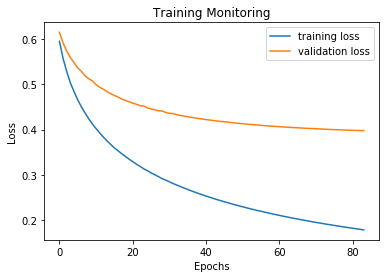

In [31]:
%matplotlib inline
fig = plt.figure()
plt.plot(range(len(loss_tr_count)),loss_tr_count,label='training loss')
plt.plot(range(len(dev_loss_count)),dev_loss_count,label='validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring')

plt.legend()
plt.show()

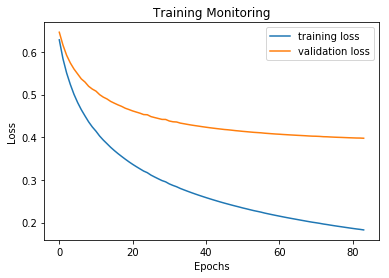

Explain here...

Compute accuracy, precision, recall and F1-scores:

In [32]:
# fill in your code...
preds_te_count = predict_class(X_te_count,w_count)

print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count))
print('Recall:', recall_score(Y_te,preds_te_count))
print('F1-Score:', f1_score(Y_te,preds_te_count))

Accuracy: 0.835
Precision: 0.8221153846153846
Recall: 0.855
F1-Score: 0.838235294117647


Finally, print the top-10 words for the negative and positive class respectively.

In [33]:
# fill in your code...
sorted_index = w_count.copy().flatten().argsort()
top_neg_ngram = [vocab[i] for i in sorted_index[:10]]
print(top_neg_ngram)

['bad', 'unfortunately', 'only', 'script', 'worst', 'why', 'boring', 'plot', 'any', 'nothing']


In [34]:
# fill in your code...
top_pos_ngram = [vocab[i] for i in sorted_index[-10:]]
print(top_pos_ngram)

['world', 'both', 'movies', 'life', 'many', 'also', 'fun', 'seen', 'well', 'great']


If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

Provide your answer here...

## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


In [35]:
w_tfidf, trl, devl = SGD(X_tr_tfidf, Y_tr, 
                         X_dev=X_dev_tfidf, 
                         Y_dev=Y_dev, 
                         lr=0.0001, 
                         alpha=0.00001, 
                         epochs=50)

Epoch: 0| Training loss: 0.653642| Validation loss: 0.663066
Epoch: 1| Training loss: 0.608030| Validation loss: 0.639611
Epoch: 2| Training loss: 0.571176| Validation loss: 0.622584
Epoch: 3| Training loss: 0.540431| Validation loss: 0.607222
Epoch: 4| Training loss: 0.514026| Validation loss: 0.593081
Epoch: 5| Training loss: 0.491017| Validation loss: 0.581390
Epoch: 6| Training loss: 0.470833| Validation loss: 0.572181
Epoch: 7| Training loss: 0.452772| Validation loss: 0.563780
Epoch: 8| Training loss: 0.436503| Validation loss: 0.555586
Epoch: 9| Training loss: 0.421777| Validation loss: 0.549104
Epoch: 10| Training loss: 0.408304| Validation loss: 0.542270
Epoch: 11| Training loss: 0.395902| Validation loss: 0.535561
Epoch: 12| Training loss: 0.384459| Validation loss: 0.529559
Epoch: 13| Training loss: 0.373820| Validation loss: 0.525842
Epoch: 14| Training loss: 0.363925| Validation loss: 0.521522
Epoch: 15| Training loss: 0.354639| Validation loss: 0.515795
Epoch: 16| Trainin

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

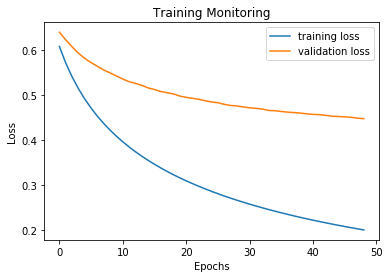

In [36]:
%matplotlib inline
fig = plt.figure()
plt.plot(range(len(trl)),trl,label='training loss')
plt.plot(range(len(devl)),devl,label='validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring')

plt.legend()
plt.show()

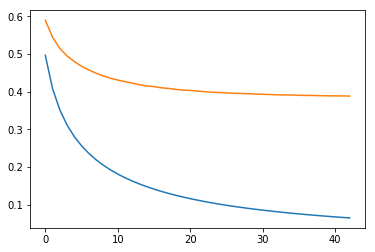

In [32]:
# fill in your code...

Compute accuracy, precision, recall and F1-scores:

In [37]:
# fill in your code...
preds_te = predict_class(X_te_tfidf,w_tfidf)

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te))
print('Recall:', recall_score(Y_te,preds_te))
print('F1-Score:', f1_score(Y_te,preds_te))

Accuracy: 0.8525
Precision: 0.8472906403940886
Recall: 0.86
F1-Score: 0.8535980148883374


Print top-10 most positive and negative words:

In [38]:
# fill in your code...
sorted_index = w_tfidf.copy().flatten().argsort()
top_neg_ngram = [vocab[i] for i in sorted_index[:10]]
print(top_neg_ngram)

['bad', 'worst', 'boring', 'supposed', 'why', 'unfortunately', 'stupid', 'harry', 'ridiculous', 'nothing']


In [39]:
# fill in your code...
top_pos_ngram = [vocab[i] for i in sorted_index[-10:]]
print(top_pos_ngram)

['world', 'memorable', 'excellent', 'perfect', 'terrific', 'hilarious', 'perfectly', 'life', 'truman', 'great']


### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

Enter your answer here...



## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |0.822   |0.855   |0.838   |
| BOW-tfidf  |0.847   |0.860   |0.853   |


# Multi-class Logistic Regression 

Now you need to train a Multiclass Logistic Regression (MLR) Classifier by extending the Binary model you developed above. You will use the MLR model to perform topic classification on the AG news dataset consisting of three classes:

- Class 1: World
- Class 2: Sports
- Class 3: Business

You need to follow the same process as in Task 1 for data processing and feature extraction by reusing the functions you wrote.

In [40]:
# fill in your code...
Data = FileLoader('data_topic',names=['label','text'])

data_tr = Data.train
data_te = Data.test
data_dev = Data.dev

Finish loading:
	train.csv
	test.csv
	dev.csv


In [41]:
data_tr.head()

,label,text
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [37]:
data_tr.head()

,label,text
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [42]:
# fill in your code...
X_tr_raw, Y_tr = transform(data_tr)
X_te_raw, Y_te = transform(data_te)
X_dev_raw, Y_dev = transform(data_dev)

In [43]:
X_tr_raw[:1]

['Reuters - Venezuelans turned out early\\and in large numbers on Sunday to vote in a historic referendum\\that will either remove left-wing President Hugo Chavez from\\office or give him a new mandate to govern for the next two\\years.']

In [44]:
Y_tr

array([[1],
       [1],
       [1],
       ...,
       [3],
       [3],
       [3]])

In [45]:
vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['reuters', 'said', 'tuesday', 'new', 'wednesday', 'after', 'athens', 'ap', 'monday', 'first', 'their', 'us', 'olympic', 'york', ('new', 'york'), 'two', 'over', 'will', 'but', 'oil', 'inc', 'more', 'prices', 'year', 'company', 'world', 'gt', 'lt', 'than', 'aug', 'about', 'had', 'one', 'united', 'out', 'sunday', 'against', 'up', 'quot', 'into', 'fullquote', 'second', 'last', 'stocks', 'team', 'president', 'gold', 'percent', 'iraq', 'three', 'when', 'greece', 'night', ('york', 'reuters'), ('new', 'york', 'reuters'), 'time', 'not', 'no', 'games', 'yesterday', 'home', 'olympics', 'washington', 'states', 'off', ('united', 'states'), 'google', ('oil', 'prices'), 'day', 'public', 'billion', 'record', ('athens', 'reuters'), 'week', 'win', 'all', 'men', 'government', 'won', ('said', 'tuesday'), 'najaf', 'american', 'years', 'officials', 'today', 'city', 'would', 'shares', 'offering', 'people', 'final', 'medal', 'minister', 'afp', 'corp', 'sales', 'million', 'back', 'four', 'investor']

[(

In [39]:
vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['questions', ('exhibition', 'game'), ('computer', 'maker'), ('chavez', 'won'), ('invoices', 'halliburton'), ('den', 'hoogenband', 'netherlands'), 'body', ('anterior', 'cruciate'), ('billion', 'cash', 'stock'), ('nortel', 'networks', 'corp'), ('offering', 'nearly'), ('prime', 'minister'), ('july', 'first', 'time'), 'strong', ('hang', 'over'), 'model', 'ease', 'assets', 'category', 'family', 'disappeared', ('olympic', 'men'), 'couldn', 'why', 'shift', ('world', 'largest', 'food'), 'oust', ('settler', 'homes'), ('jerusalem', 'reuters'), ('wisconsin', 'reuters'), 'luis', 'bowl', ('monday', 'said', 'quarterly'), ('baltimore', 'orioles'), ('more', 'israeli'), ('army', 'had', 'decided'), 'economic', ('after', 'web', 'no'), 'lynn', ('defensive', 'end'), 'according', 'facilities', ('company', 'wednesday'), ('lt', 'gt', 'wednesday'), 'tutsi', ('dillard', 'inc'), 'outside', 'protect', 'uk', 'weather', 'sell', 'pile', 'immediately', 'senate', ('venus', 'williams'), ('four', 'months'), 'pope

In [46]:
# fill in your code...
X_tr_ngram = [extract_ngrams(line,ngram_range=(1,3),stop_words=stop_words) for line in X_tr_raw]
X_te_ngram = [extract_ngrams(line,ngram_range=(1,3),stop_words=stop_words) for line in X_te_raw]
X_dev_ngram = [extract_ngrams(line,ngram_range=(1,3),stop_words=stop_words) for line in X_dev_raw]

X_tr_count = vectorise(X_tr_ngram, vocab)
X_te_count = vectorise(X_te_ngram, vocab)
X_dev_count = vectorise(X_dev_ngram, vocab)

Now you need to change `SGD` to support multiclass datasets. First you need to develop a `softmax` function. It takes as input:

- `z`: array of real numbers 

and returns:

- `smax`: the softmax of `z`

In [47]:
def softmax(z):
    
    # fill in your code...
    z = z.copy()
    #z -= np.max(z)
    smax = np.exp(z) / np.sum(np.exp(z),axis=1,keepdims=True)
    
    return smax

Then modify `predict_proba` and `predict_class` functions for the multiclass case:

In [97]:
def predict_proba(X, weights):
    
    # fill in your code...
    preds_proba = X.dot(weights.T)
    
    assert preds_proba.shape == (X.shape[0],weights.shape[0])
    return softmax(preds_proba)

In [49]:
def predict_class(X, weights):
    
    # fill in your code...
    classes = np.array(range(X.shape[1]))+1
    preds_proba = predict_proba(X, weights)
    preds_class = preds_proba-preds_proba.max(axis=1,keepdims=True)
    preds_class = np.where(preds_class==0,1,0).dot(classes).flatten()
    
    assert preds_class.shape == (X.shape[0],)
    return preds_class

In [50]:
X = np.array([[0.1,0.2],[0.2,0.1],[0.1,-0.2]])
w = np.array([[2,-5],[-5,2]])

In [51]:
predict_proba(X, w)

array([[-0.8, -0.1],
       [-0.1, -0.8],
       [ 1.2, -0.9]])

In [52]:
predict_class(X, w)

array([2, 1, 1])

Toy example and expected functionality of the functions above:

In [151]:
X = np.array([[0.1,0.2],[0.2,0.1],[0.1,-0.2]])
w = np.array([[2,-5],[-5,2]])

In [46]:
predict_proba(X, w)

array([[0.33181223, 0.66818777],
       [0.66818777, 0.33181223],
       [0.89090318, 0.10909682]])

In [47]:
predict_class(X, w)

array([2, 1, 1])

Now you need to compute the categorical cross entropy loss (extending the binary loss to support multiple classes).

In [111]:
def categorical_loss(X, Y, weights, num_classes=5, alpha=0.00001):
    
    # fill in your code...
    assert Y.shape[0] == X.shape[0]
    #assert num_classes == weights.shape[0]
    eps = np.finfo(np.float64).eps
    preds_proba = predict_proba(X, weights)
    
    Y = np.eye(X.shape[0],weights.shape[0])[Y-1].reshape(X.shape[0],weights.shape[0])
    l = -np.sum(Y*np.log(predict_proba(X,weights)+eps),1) + alpha*np.dot(weights, weights.T)
    l=np.mean(l)
    return l
    

In [130]:
def gradient(X, Y, weights, alpha=0.00001):
    m = len(X)
    Y = np.eye(X.shape[0],weights.shape[0])[Y-1].reshape(X.shape[0],weights.shape[0])
    h = predict_proba(X, weights)
    dw = -np.dot((Y-Y*h).T,X) + 2*alpha*weights
    assert dw.shape == weights.shape
    return dw/m

In [159]:
X = np.array([[0.1,0.2],[0.2,0.1],[0.1,-0.2]])
w = np.array([[2.0,-5.0],[-5.0,2.0]])
Y = np.array([[1],[2],[1]])
pre_loss = categorical_loss(X,Y,w)

In [160]:
for i in range(9999):
    w -= 20*gradient(X,Y,w)
    now_loss = categorical_loss(X,Y,w)
    if i%199 == 0:
        print(now_loss)
    if now_loss > pre_loss:
        break
    else:
        pre_loss = now_loss

0.7627377308595852


In [161]:
now_loss

0.6729259065275066

Finally you need to modify SGD to support the categorical cross entropy loss:

In [49]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], num_classes=5, lr=0.01, alpha=0.00001, epochs=5, tolerance=0.001, print_progress=True):
    
    # fill in your code...

    return weights, training_loss_history, validation_loss_history

In [ ]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], loss="binary", lr=0.1, alpha=0.00001, epochs=5, tolerance=0.0001, print_progress=True):
    
    cur_loss_tr = 1.
    cur_loss_dev = 1.
    training_loss_history = []
    validation_loss_history = []
    
    # fill in your code...
    
    # Stage 1: Init weights
    #weights = np.random.rand(1,X_tr.shape[1])
    weights = np.zeros((1,X_tr.shape[1]))
    
    # Stage 2: Init stochastic value
    idx_list = np.array(range(X_tr.shape[0]))
    
    # Stage 3: Training
    for epoch in range(epochs):
        loss_tr = 0
        np.random.shuffle(idx_list) # disorder dataset
        for i in idx_list:
            X_tr_i, Y_tr_i = X_tr[i].reshape(1,-1),Y_tr[i].reshape(1,-1) # get a single data pair
            dw = gradient(X_tr_i, Y_tr_i, weights, alpha=0.00001) # gradient
            weights -= lr*dw # update
            loss_tr += binary_loss(X_tr_i, Y_tr_i, weights, alpha) # add loss
        
        loss_dev = binary_loss(X_dev_count, Y_dev, weights, alpha)
        loss_tr /= len(idx_list)
        # Add history
        if epoch != 0:
            training_loss_history.append(loss_tr)
            validation_loss_history.append(loss_dev)
        if print_progress == True: 
            print("Epoch: %d| Training loss: %f| Validation loss: %f"%(epoch,loss_tr,loss_dev))
        if epoch >1 and abs(validation_loss_history[-2]-validation_loss_history[-1]) <= tolerance:
            break

    return weights, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you MLR following the same steps as in Task 1 for both Count and tfidf features:

In [50]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, Y_tr, 
                                             X_dev=X_dev_count, 
                                             Y_dev=Y_dev,
                                             num_classes=3,
                                             lr=0.0001, 
                                             alpha=0.001, 
                                             epochs=200)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Epoch: 0| Training loss: 1.0797445295473487| Validation loss: 1.081372090349833
Epoch: 1| Training loss: 1.079316160352198| Validation loss: 1.0640685482079149
Epoch: 2| Training loss: 1.0560473439817515| Validation loss: 1.0466716664674833
Epoch: 3| Training loss: 1.0823272116547453| Validation loss: 1.0293144599016153
Epoch: 4| Training loss: 1.0541411400498168| Validation loss: 1.0120430537618956
Epoch: 5| Training loss: 0.6018201485747277| Validation loss: 0.9949501699020834
Epoch: 6| Training loss: 0.9408020769124341| Validation loss: 0.9780518842493735
Epoch: 7| Training loss: 0.9785218029526777| Validation loss: 0.961399507260303
Epoch: 8| Training loss: 1.105504123262664| Validation loss: 0.945017429821232
Epoch: 9| Training loss: 0.9330426453622344| Validation loss: 0.9289397744769093
Epoch: 10| Training loss: 0.7202271854150083| Validation loss: 0.9131712383598369
Epoch: 11| Training loss: 0.980165568395653| Validation loss: 0.8977588631301825
Epoch: 12| Training loss: 0.9350

Epoch: 100| Training loss: 0.5909452468922335| Validation loss: 0.3308943792523601
Epoch: 101| Training loss: 0.0582537404726638| Validation loss: 0.3286410364885621
Epoch: 102| Training loss: 0.8460500582683682| Validation loss: 0.32641969802577286
Epoch: 103| Training loss: 0.5298538159246153| Validation loss: 0.324225708977352
Epoch: 104| Training loss: 0.3002611196487631| Validation loss: 0.3220709147432522
Epoch: 105| Training loss: 0.6857676458335961| Validation loss: 0.31995106501678755
Epoch: 106| Training loss: 0.5195060392225062| Validation loss: 0.31785403975508386
Epoch: 107| Training loss: 0.6192846034415994| Validation loss: 0.3157920207863501
Epoch: 108| Training loss: 0.09917322459957126| Validation loss: 0.31376264796419107
Epoch: 109| Training loss: 0.3136491065708976| Validation loss: 0.3117644717911298
Epoch: 110| Training loss: 0.2961228303588815| Validation loss: 0.30979000698586306
Epoch: 111| Training loss: 0.028415357821764815| Validation loss: 0.30785497759094

Plot training and validation process and explain if your model overfit, underfit or is about right:

In [2]:
# fill in your code...

Compute accuracy, precision, recall and F1-scores:

In [6]:
# fill in your code...

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Print the top-10 words for each class respectively.

In [7]:
# fill in your code...

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

Explain here...

### Now evaluate BOW-tfidf...

## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |   |   |   |
| BOW-tfidf  |   |   |   |
